Testing the stella package to look for flares. 20200917 tensorflow not working

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
"""eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']


fitter = fitting.LevMarLSQFitter()




for tessfits in eg_uma_fits:
    data = fits.getdata(tessfits, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    lc = lk.LightCurve(time=t, flux=f, flux_err=e).flatten(window_length=1001)#remove_outliers(sigma=5).
    lc = lc.remove_nans()
  #  lc.flux -= 1
   # lc.flux  *= 100
    #lc.flux_err *= 100
    plt.scatter(lc.time,lc.flux, s=5)
    plt.show()"""

"eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',\n'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']\n\n\nfitter = fitting.LevMarLSQFitter()\n\n\n\n\nfor tessfits in eg_uma_fits:\n    data = fits.getdata(tessfits, 1)\n    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']\n    t, f, e = t[q==0], f[q==0], e[q==0]\n    lc = lk.LightCurve(time=t, flux=f, flux_err=e).flatten(window_length=1001)#remove_outliers(sigma=5).\n    lc = lc.remove_nans()\n  #  lc.flux -= 1\n   # lc.flux  *= 100\n    #lc.flux_err *= 100\n    plt.scatter(lc.time,lc.flux, s=5)\n    plt.show()"

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

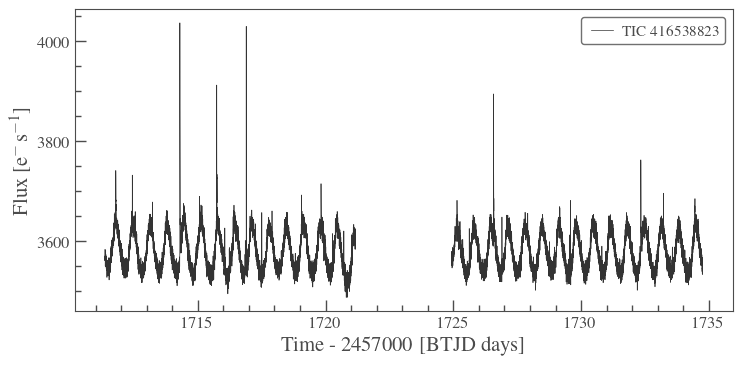

In [26]:
from lightkurve.search import search_lightcurvefile

lc = search_lightcurvefile(target='tic416538823', mission='TESS', sector=15)
lc = lc.download().PDCSAP_FLUX
lc.plot()

In [27]:
lc=lc.remove_nans()

In [28]:
import stella

In [29]:
MODEL_DIR = '/media/david/5tb_storage1/stella/models/run01/'
MODELS = [os.path.join(MODEL_DIR,i) for i in
          os.listdir(MODEL_DIR) if i.endswith('.h5')]
print(MODELS)

['/media/david/5tb_storage1/stella/models/run01/ensemble_s0004_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0005_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0018_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0028_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0029_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0038_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0050_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0077_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0078_i0350_b0.73.h5', '/media/david/5tb_storage1/stella/models/run01/ensemble_s0080_i0350_b0.73.h5']


In [30]:
OUT_DIR = '/media/david/5tb_storage1/stella/output/'

In [31]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


In [32]:
cnn.predict(modelname=MODELS[0],
            times=lc.time,
            fluxes=lc.flux,
            errs=lc.flux_err)
single_pred = cnn.predictions[0]



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [33]:
cnn.model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 16)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

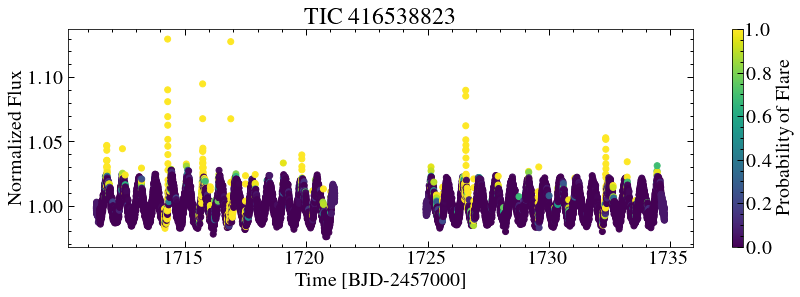

In [34]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));

In [35]:
preds = np.zeros((len(MODELS),len(cnn.predictions[0])))

for i, model in enumerate(MODELS):
    cnn.predict(modelname=model,
                times=lc.time,
                fluxes=lc.flux,
                errs=lc.flux_err)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


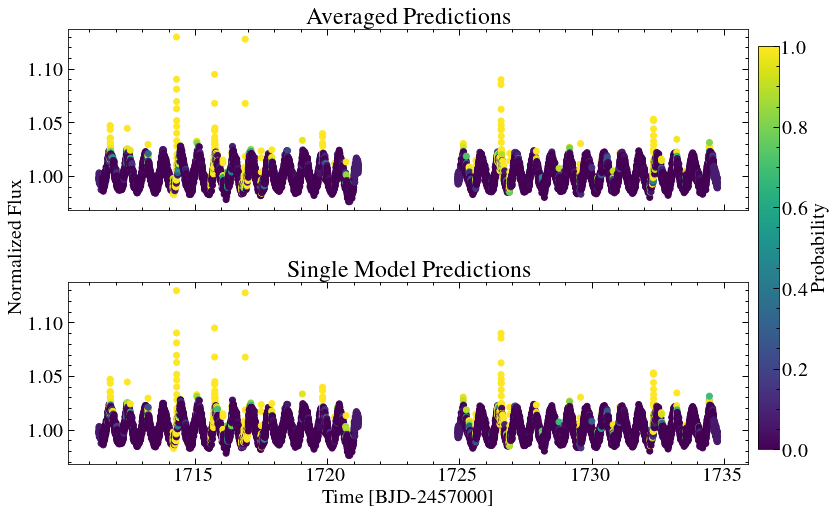

In [36]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);



(1906.0, 1908.0)

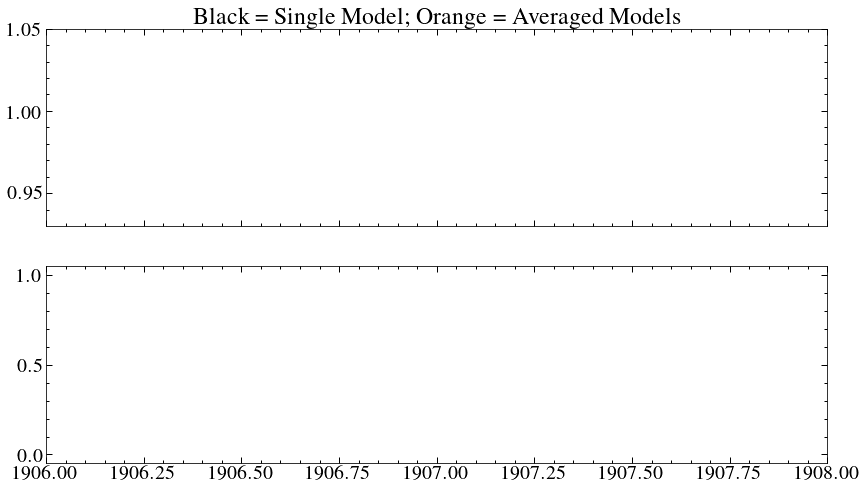

In [37]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0]-0.03,
            c=single_pred, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn.predict_time[0], single_pred, 'k')
ax2.plot(cnn.predict_time[0], avg_pred, 'orange')
ax1.set_title('Black = Single Model; Orange = Averaged Models')

plt.xlim(1906, 1908)


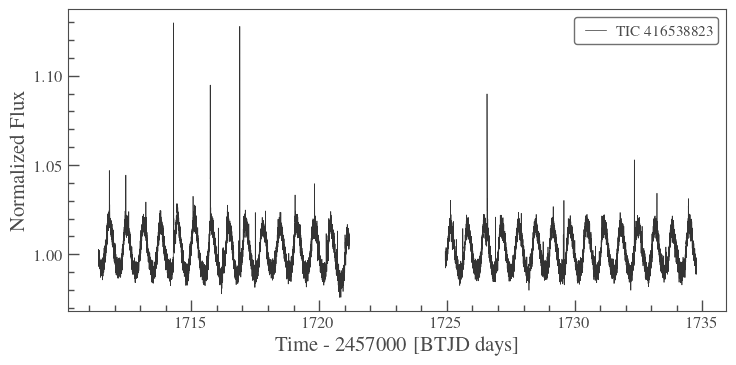

In [47]:
from lightkurve.search import search_lightcurvefile
lc = search_lightcurvefile(target='tic416538823', mission='TESS', sector=15)
lc = lc.download().PDCSAP_FLUX.normalize()
lc.plot()
lc = lc.remove_nans()

In [48]:
mProt = stella.MeasureProt([lc.targetid], [lc.time], [lc.flux], [lc.flux_err])



In [49]:
mProt.run_LS()

Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


In [50]:
mProt.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
416538823,0.6678640633439006,0.6670240431443578,0.016789674572216574,0.7665382324887284,0.1502017119625505,0.0,0.0,0.0,0,0.6678640633439006


<AxesSubplot:xlabel='Phase', ylabel='Normalized Flux'>

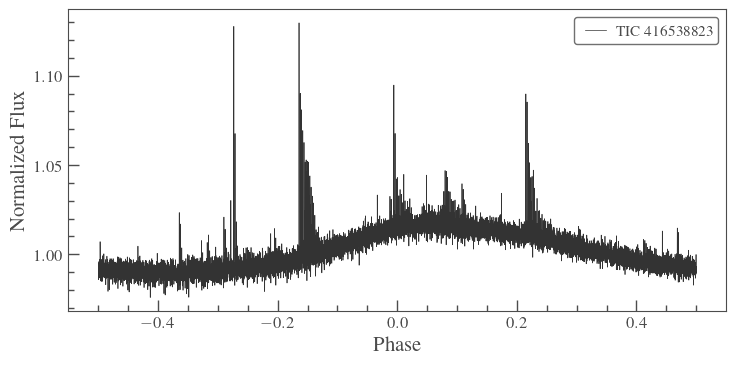

In [51]:
lc.fold(mProt.LS_results['avg_period_days'].data[0]).plot()

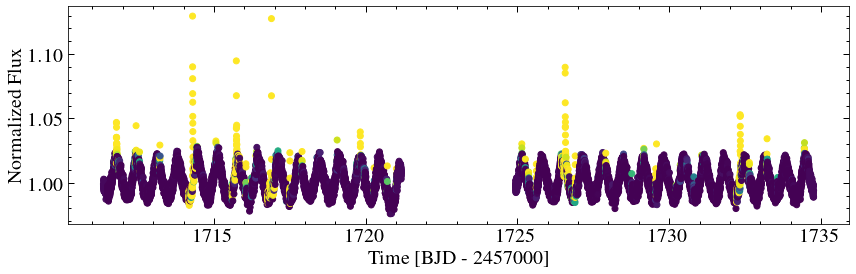

In [52]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0], c=cnn.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [53]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time],
                      flux=[lc.flux],
                      flux_err=[lc.flux_err],
                      predictions=[cnn.predictions[0]])

In [54]:
ff.identify_flare_peaks(threshold=0.5)

ff.flare_table



Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
416538823.0,1711.7890001081478,1.0253321950770728,19.346616036541526,0.0001,0.007807980365746259,1.0
416538823.0,1711.875110002491,1.0046273314882654,1.1826341524826058,0.0001,0.002046579628224522,0.6426543593406677
416538823.0,1712.4362135384747,1.0267092532088162,4.714567913810649,0.0001,0.0012473596116767637,0.9999743700027466
416538823.0,1712.550100955433,1.0125992507844337,2.279635273429826,0.0001,0.0012734538912838394,0.9704247713088989
416538823.0,1713.2209260027817,1.017953302327545,4.014228175782255,0.0001,0.0018343268278190677,0.9995187520980835
416538823.0,1714.204248251936,1.0046954469405647,4.036315111155355,0.0001,0.01,0.9999995231628418
416538823.0,1714.2973028193699,1.1286915554692445,90.14627447508278,0.0001,0.0077189327586148675,1.0
416538823.0,1714.436190252222,1.0083415802787687,7.970259267184335,0.0001,0.01,0.995086133480072
416538823.0,1715.0667394776435,1.0163216018849954,4.037104833525234,0.0001,0.0019662606737756018,0.9922400712966919


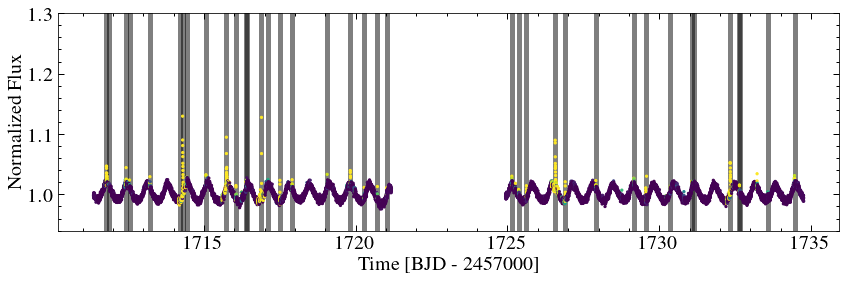

In [55]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');


(array([12713.,   163.,    86.,    59.,    54.,    45.,    39.,    41.,
           58.,   666.]),
 array([9.918418e-19, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

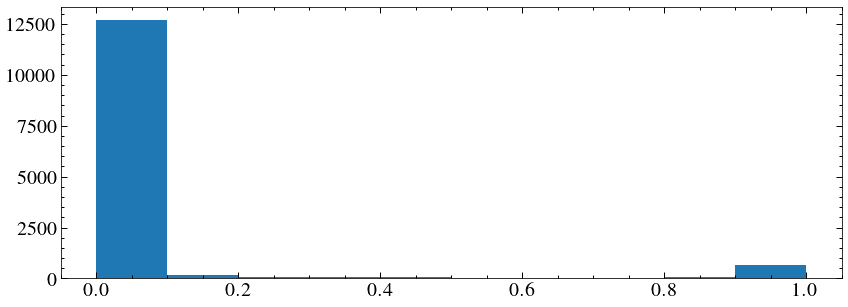

In [56]:
plt.hist(cnn.predictions[0], bins=10)

In [57]:
len(cnn.predictions[0][cnn.predictions[0]>0.5])/len(cnn.predictions[0])*100

6.097385808675668